# Workshop Prático: Classificação de Sinais de Libras

---

## 1. Setup do Ambiente
Instalando dependências e baixando o dataset.

In [ ]:
# Instalar Kaggle e outras bibliotecas
!pip install -q opencv-python matplotlib torch torchvision albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.1 MB/s eta 0:00:00


In [ ]:
# Download e descompactação do dataset
!curl -L -o ~/libras.zip https://www.kaggle.com/api/v1/datasets/download/williansoliveira/libras
!unzip -q ~/libras.zip -d ~/libras

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  289M  100  289M    0     0  99.5M      0  0:00:02  0:00:02 --:--:--  126M


## 2. Análise Exploratória do Dataset
Vamos entender quantas classes existem, quantas imagens por classe e visualizar exemplos.

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

base_dir = '/root/libras'
splits = ['train', 'test', 'val']
class_counts = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    classes = os.listdir(split_dir)
    for cls in classes:
        count = len(os.listdir(os.path.join(split_dir, cls)))
        class_counts.append({"label": cls, "split": split, "count": count})

# Mostrar contagem de imagens por classe
import pandas as pd
# df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
df_counts = pd.DataFrame(class_counts)
df_counts.sort_values(["split", "label"], ascending=True)


,label,split,count
32,A,test,579
36,B,test,562
30,C,test,583
24,D,test,550
40,E,test,574
...,...,...,...
49,T,val,1000
50,U,val,1000
43,V,val,1000
44,W,val,1000


In [ ]:
# Cria pasta de validação

from glob import glob
import random

for cls in os.listdir(os.path.join(base_dir, 'train')):
  imgs_path = glob(os.path.join(base_dir, 'train', cls, '*'))
  random.shuffle(imgs_path)
  imgs_path = imgs_path[:500]
  os.makedirs(os.path.join(base_dir, 'val', cls), exist_ok=True)
  for img_path in imgs_path:
    os.rename(img_path, img_path.replace('train', 'val'))

### 2.1 Visualizando Exemplo de Cada Classe

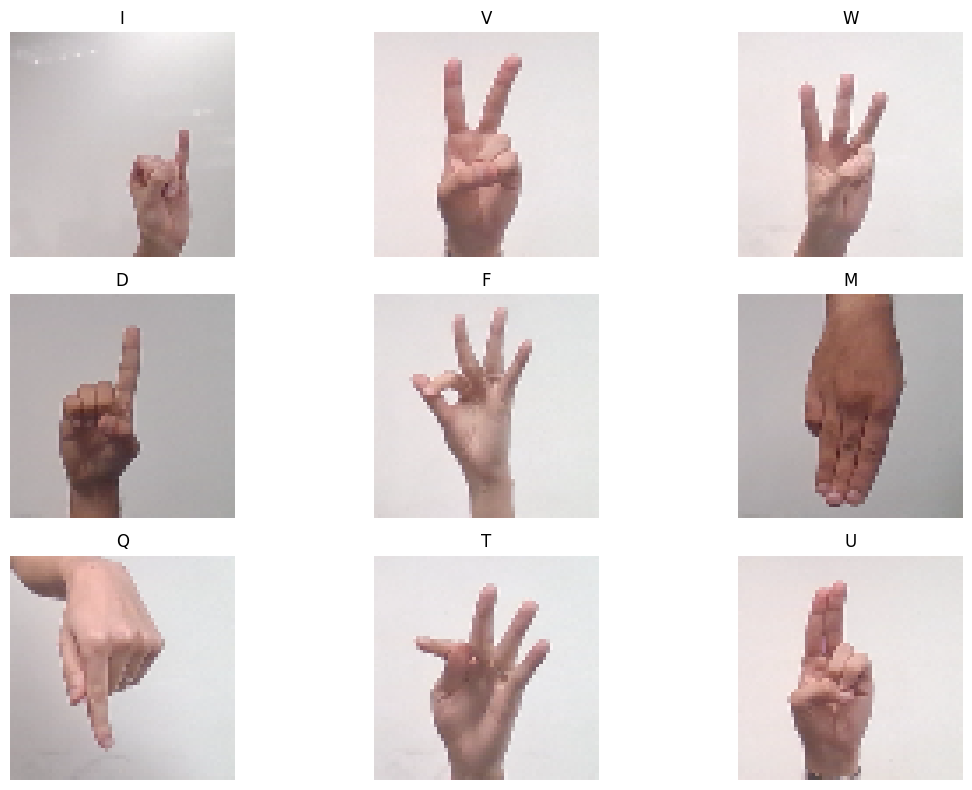

In [ ]:
plt.figure(figsize=(12, 8))
for i, cls in enumerate(os.listdir(os.path.join(base_dir, 'train'))[:9]):
    img_path = os.path.join(base_dir, 'train', cls, os.listdir(os.path.join(base_dir, 'train', cls))[0])
    img = cv2.imread(img_path)[:, :, ::-1]
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()


## 3. Pré-processamento e Augmentations

### 3.1 Augmentations
Testaremos diferentes transformações e veremos seus efeitos.

https://github.com/albumentations-team/albumentations?tab=readme-ov-file#list-of-augmentations

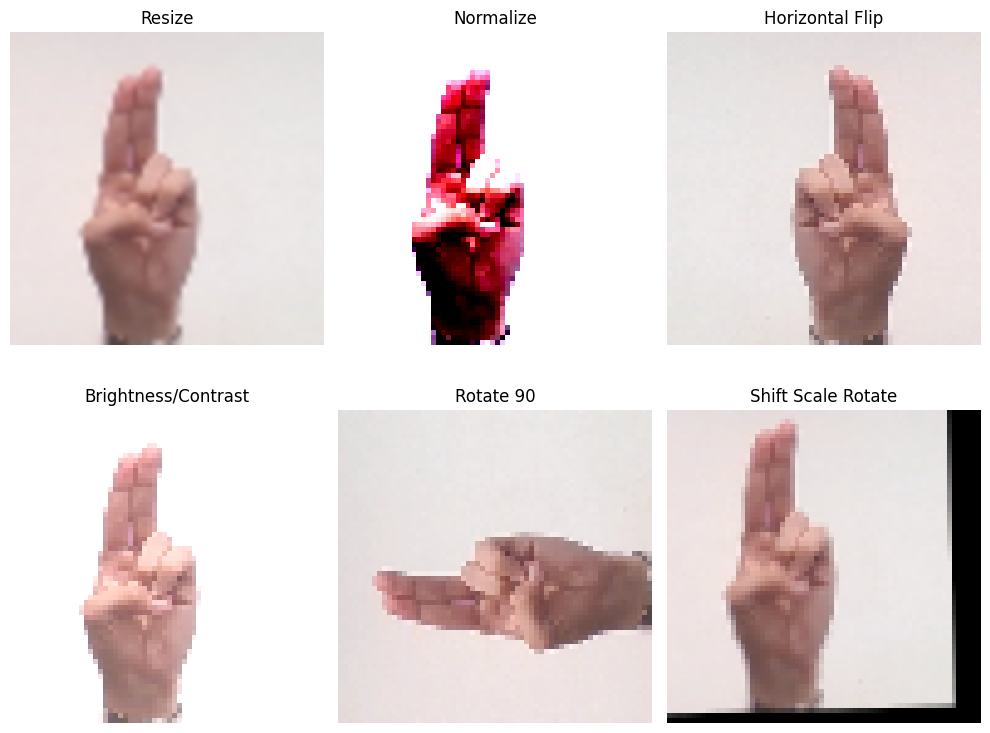

In [ ]:
from albumentations import Compose, Resize, RandomRotate90, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate, Normalize
import numpy as np

# Carregar imagem de exemplo
sample_img = img

# Definir transformações
transforms = {
    'Resize': Compose([Resize(128, 128)]),
    'Normalize': Compose([Normalize()]),
    'Horizontal Flip': Compose([HorizontalFlip(p=1.0)]),
    'Brightness/Contrast': Compose([RandomBrightnessContrast(p=1.0)]),
    'Rotate 90': RandomRotate90(p=1.0),
    'Shift Scale Rotate': ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1.0),
}

# Aplicar e visualizar
plt.figure(figsize=(10, 8))
for i, (name, tfm) in enumerate(transforms.items()):
    aug = tfm(image=sample_img)
    aug_img = aug['image']
    if aug_img.ndim == 2: aug_img = np.stack([aug_img]*3, axis=-1)
    plt.subplot(2, 3, i+1)
    plt.imshow(aug_img)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()


### 3.2 Pipeline de Augmentations com Compose
Neste exemplo, combinamos várias transformações em um único pipeline `Compose` para aplicar às imagens de forma encadeada.


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

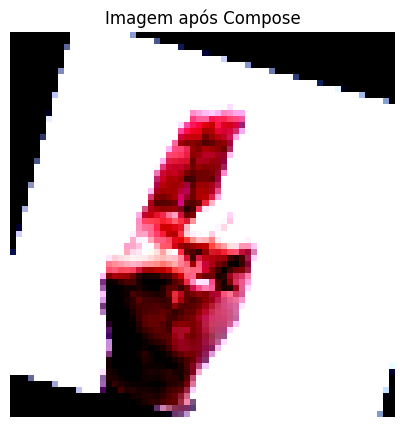

In [ ]:
from albumentations import Compose, RandomRotate90, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate, Normalize
import matplotlib.pyplot as plt

# Definindo um pipeline de augmentations
pipeline = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    Normalize()
])

# Aplicando no sample_img previamente carregado
augmented = pipeline(image=sample_img)
aug_img = augmented['image']

# Visualização
plt.figure(figsize=(5,5))
plt.imshow(aug_img)
plt.title('Imagem após Compose')
plt.axis('off')


### 3.3 Funções de Pré-processamento
Definimos funções para aplicar diferentes filtros e realces na imagem antes do treinamento. A seguir, 5 exemplos:
1. Unsharp Mask  
2. Gaussian Blur  
3. Median Blur  
4. Equalize Histogram  
5. Sharpen (Convolução)


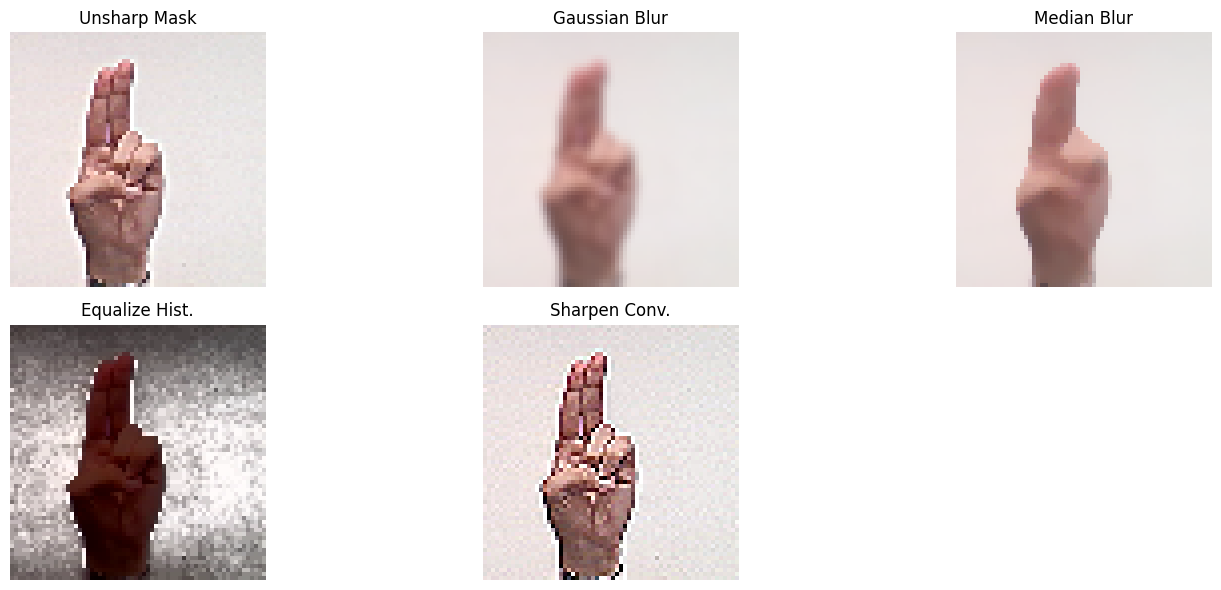

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def unsharp_mask(image, kernel_size=(5,5), sigma=1.0, amount=1.5, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    if threshold > 0:
        low_contrast = np.abs(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast)
    return sharpened

def gaussian_blur(image, kernel_size=(5,5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def median_blur(image, ksize=5):
    return cv2.medianBlur(image, ksize)

def equalize_histogram(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def sharpen_convolution(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Aplicando e visualizando cada filtro
filters = {
    'Unsharp Mask': unsharp_mask,
    'Gaussian Blur': gaussian_blur,
    'Median Blur': median_blur,
    'Equalize Hist.': equalize_histogram,
    'Sharpen Conv.': sharpen_convolution
}

plt.figure(figsize=(15, 6))
for i, (name, func) in enumerate(filters.items()):
    result = func(sample_img)
    plt.subplot(2, 3, i+1)
    plt.imshow(result)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()


## 4. Definição da Arquitetura e Hiperparâmetros
Usaremos ResNet-18 pretrained para classificação.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets

# Hiperparâmetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 2

# Definição do modelo
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(os.listdir(os.path.join(base_dir, 'train'))))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# add model summary

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


## 5. Treinamento do Modelo

In [ ]:
# Preparar dataloaders
data_transforms = {
    'train': transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]),
    'val': transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]),
    'test': transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x]) for x in splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in splits}

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Loop de treino
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


Epoch 1/2


100%|██████████| 429/429 [01:01<00:00,  7.01it/s]


train Loss: 0.1201 Acc: 0.9692


100%|██████████| 657/657 [00:50<00:00, 12.95it/s]


val Loss: 0.1926 Acc: 0.9440
Epoch 2/2


100%|██████████| 429/429 [00:59<00:00,  7.21it/s]


train Loss: 0.0074 Acc: 0.9982


100%|██████████| 657/657 [00:50<00:00, 13.03it/s]

val Loss: 0.0009 Acc: 1.0000


## 6. Avaliação do Modelo

In [ ]:
classes = image_datasets['train'].classes

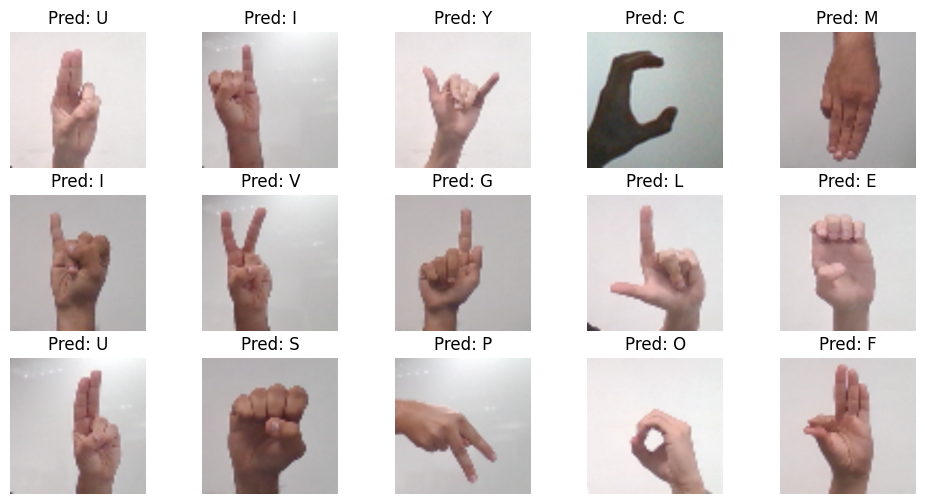

In [ ]:
# Exemplo de avaliação simples em validation set
model.eval()
inputs, labels = next(iter(dataloaders['val']))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Mostrar 15 imagens e predições
plt.figure(figsize=(12, 6))
for i in range(15):
    img = inputs[i].cpu().permute(1,2,0).numpy()
    plt.subplot(3,5,i+1)
    plt.imshow(img)
    pred = image_datasets['val'].classes[preds[i]]
    plt.title(f'Pred: {pred}')
    plt.axis('off')
plt.show()


## 7. Salvando o modelo + arquitetura
Salvando tanto os pesos quanto a arquitetura do modelo em um único arquivo `model.pth`

In [ ]:
torch.save(model, 'model.pth') # Salva os pesos, kernels e arquitetura de forma geral

## 8. Inferência

Tire uma foto e faça o upload dela para o Colab.
Depois faça a inferência do modelo na sua imagem.

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Transforms iguais aos usados durante o treinamento
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


# Carregar a imagem
img_path = "/content/WhatsApp Image 2025-08-09 at 11.35.31.jpeg"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # (1, C, H, W)


In [ ]:
model.eval()
with torch.no_grad():
    output = model(input_tensor.to(device))
    _, pred = torch.max(output, 1)
    predicted_class = classes[pred.item()]
    print(f"Classe predita: {predicted_class}")

Classe predita: L


## 9. Construindo a API

Gerando `app.py`

In [ ]:
%%bash
cat > app.py <<'EOF'


from flask import Flask, request, render_template
import torch
from torchvision import transforms
from PIL import Image
import io, os, base64

# Configura Flask
app = Flask(__name__)

# --- Carrega o modelo e ready ---
model = torch.load('model.pth', map_location='cpu', weights_only=False)
model.eval()

# Transformação de pré-processamento
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

@app.route('/', methods=['GET'])
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # checa upload
    if 'file' not in request.files:
        return render_template('index.html', error='Nenhum arquivo enviado.')
    file = request.files['file']
    if file.filename == '':
        return render_template('index.html', error='Arquivo inválido.')

    # lê imagem
    img = Image.open(io.BytesIO(file.read())).convert('RGB')
    tensor = transform(img).unsqueeze(0)
    out = model(tensor)
    _, pred = torch.max(out, 1)
    # pega nome da classe
    label = ['A','B','C','D','E','F','G','I','L','M','N','O','P','Q','R','S','T','U','V','W','Y'][pred.item()]

    # converte imagem para base64
    buff = io.BytesIO()
    img.save(buff, format="JPEG")
    img_str = base64.b64encode(buff.getvalue()).decode()

    return render_template('index.html', prediction=label, img_data=img_str)

if __name__ == '__main__':
    # debug=True recarrega ao editar o template
    app.run(host='0.0.0.0', port=5000, debug=True)

EOF

Gerando `templates/index.html`

In [ ]:
%%bash
mkdir -p templates

cat > templates/index.html <<'EOF'
<!doctype html>
<html lang="pt-br">
  <head>
    <meta charset="utf-8">
    <title>Classificador de Libras</title>
    <style>
      body {
        font-family: Arial, sans-serif;
        text-align: center;
        background-color: #f0f8ff;
        margin: 0;
        padding: 0;
      }
      .container {
        max-width: 600px;
        margin: 30px auto;
        background-color: #ffffff;
        padding: 30px;
        border-radius: 12px;
        box-shadow: 0 0 10px rgba(0,0,0,0.1);
      }
      h1 {
        margin-bottom: 20px;
        color: #004080;
      }
      img.banner {
        width: 100%;
        border-bottom: 1px solid #ccc;
        margin-bottom: 20px;
        border-radius: 12px 12px 0 0;
      }
      input[type="file"] {
        margin: 20px 0;
      }
      button {
        background-color: #007BFF;
        color: white;
        border: none;
        padding: 10px 20px;
        font-size: 16px;
        border-radius: 8px;
        cursor: pointer;
      }
      button:hover {
        background-color: #0056b3;
      }
      .result {
        margin-top: 20px;
      }
      .uploaded-img {
        max-width: 300px;
        margin-top: 10px;
      }
    </style>
  </head>
  <body>
    <div class="container">
      <img src="{{ url_for('static', filename='banner.png') }}" class="banner" alt="LIBRAS Banner">

      <h1>Classificador de Sinais de Libras</h1>

      {% if error %}
        <p style="color:red">{{ error }}</p>
      {% endif %}

      <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*" required>
        <br>
        <button type="submit">Enviar imagem</button>
      </form>

      {% if prediction %}
        <div class="result">
          <h2>Predição: {{ prediction }}</h2>
          <img src="data:image/jpeg;base64,{{ img_data }}" class="uploaded-img" alt="Imagem Enviada">
        </div>
      {% endif %}
    </div>
  </body>
</html>

EOF

Faça o download de uma imagem para o front-end e salve-a com como `static/banner.png`

In [ ]:
!wget https://www.handtalk.me/br/wp-content/uploads/sites/8/2023/03/179-capa-blog-post_libras-1.png

--2025-08-09 14:51:29--  https://www.handtalk.me/br/wp-content/uploads/sites/8/2023/03/179-capa-blog-post_libras-1.png
Resolving www.handtalk.me (www.handtalk.me)... 104.21.15.141, 172.67.162.197, 2606:4700:3037::ac43:a2c5, ...
Connecting to www.handtalk.me (www.handtalk.me)|104.21.15.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626658 (612K) [image/png]
Saving to: ‘179-capa-blog-post_libras-1.png’

179-capa-blog-post_ 100%[===================>] 611.97K  3.38MB/s    in 0.2s    

2025-08-09 14:51:30 (3.38 MB/s) - ‘179-capa-blog-post_libras-1.png’ saved [626658/626658]



In [ ]:
!mkdir -p static
!mv 179-capa-blog-post_libras-1.png static/banner.png

Gerando `requirements.txt`

In [ ]:
%%bash

cat >  requirements.txt <<'EOF'
flask
torch
torchvision
pillow

EOF

Gerando `README.md`

In [ ]:
%%bash

cat >  README.md <<'EOF'
# Classificador de Sinais de Libras — Workshop (Prática)

Este repositório contém uma API de **classificação de sinais de Libras**. Inclui:
- **API Flask** para inferência por HTTP.
- **Front-end simples (HTML)** para upload de imagens e visualização da predição.

> O fluxo recomendado é rodar **localmente com `venv`** (ambiente virtual do Python).

## 📁 Estrutura sugerida do projeto

```
.
├── app.py                      # API Flask + front-end
├── static/
│   └── banner.png              # Imagem do banner da página
├── templates/
│   └── index.html              # Front-end (form de upload)
├── requirements.txt            # Dependências
├── README.md                   # Documentação
└── model_weights.pth           # Pesos do classificador

```

## 🧰 Requisitos
- Python **3.10+**
- `pip` atualizado

### Bibliotecas principais
- `flask`, `torch`, `torchvision`, `pillow`

Arquivo `requirements.txt` sugerido:
```
flask
torch
torchvision
pillow
```

## 🧪 Como rodar localmente com `venv`

**Windows (PowerShell):**
```powershell
python -m venv venv
.
env\Scripts\Activate.ps1
```

**macOS / Linux:**
```bash
python3 -m venv venv
source venv/bin/activate
```

Instale as dependências:
```bash
pip install -r requirements.txt
```

Rode a aplicação:
```bash
python app.py
```

Acesse: [http://localhost:5000](http://localhost:5000)

## 🌐 API HTTP

### `POST /predict` — Classificação
- Entrada: imagem no campo `file` (`multipart/form-data`).
- Saída: JSON com classe predita


## 📝 Licença
MIT License


EOF

Gerando `.gitignore`

In [ ]:
%%bash

cat >  .gitignore <<'EOF'
venv/
__pycache__/
*.pyc
*.pyo
*.pyd
.DS_Store
*.ipynb_checkpoints

EOF

Compactando todos os arquivos da API

In [ ]:
!zip -r libras_api.zip app.py templates static model_weights.pth requirements.txt model.pth README.md .gitignore

	zip warning: name not matched: model_weights.pth
  adding: app.py (deflated 49%)
  adding: templates/ (stored 0%)
  adding: templates/index.html (deflated 59%)
  adding: static/ (stored 0%)
  adding: static/banner.png (deflated 0%)
  adding: requirements.txt (deflated 9%)
  adding: model.pth (deflated 7%)
  adding: README.md (deflated 46%)
  adding: .gitignore (deflated 13%)


In [ ]:
from google.colab import files
files.download('libras_api.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testar a API local:

1. Crie o ambiente virtual

    ```json
    python3 -m venv venv
    ```

2. Ative o ambiente virtual

*   Linux/macOS:
    ```json
    source venv/bin/activate
    ```

*   Windows (CMD):
    ```json
    venv\Scripts\activate
    ```

*   Windows (PowerShell):
    ```json
    .\venv\Scripts\Activate.ps1
    ```

3. Instale as dependências
    ```json
    pip install -r requirements.txt
    ```
4. Rode o app
    ```json
    python app.py
    ```

## Git


### A. Criar sua conta (se ainda não tem)
1. Acesse **https://github.com** e crie uma conta.
2. Confirme seu e‑mail.

### B. Instalar o Git
- **Windows**: baixe em https://git-scm.com/download/win e avance com as opções padrão.
- **macOS**: `xcode-select --install` ou baixe em https://git-scm.com/download/mac
- **Linux** (Debian/Ubuntu): `sudo apt-get install git`

### C. Configurar o Git no seu computador
Abra o **Terminal** (ou PowerShell no Windows) e rode:
```bash
git config --global user.name "Seu Nome"
git config --global user.email "seuemail@exemplo.com"
```

### D. Logado no GitHub, clique em New (novo repositório).

Dê um nome, por exemplo: libras-classifier.

Deixe “Public”.

Clique em Create repository.

### E. No terminal do seu computador:
Navegue até a pasta do projeto:
```bash
cd  /caminho/da/sua/pasta/
```

E execute os seguintes comandos:
```bash
# Inicia o repositório local
git init

# Adiciona todos os arquivos para versionamento
git add .

# Faz o primeiro commit
git commit -m "Primeiro commit - Classificador de Libras"

# Adiciona o repositório remoto do GitHub
git remote add origin https://github.com/SEU_USUARIO/libras-classifier.git

# Envia para o GitHub
git branch -M main
git push -u origin main
```

# Modelo de detecção

In [ ]:
!wget -O best.pt https://raw.githubusercontent.com/RionDsilvaCS/yolo-hand-pose/main/model/best.pt

In [ ]:
# https://github.com/RionDsilvaCS/yolo-hand-pose.git

from ultralytics import YOLO
from PIL import Image

model = YOLO("best.pt")

img_path = ""

results = model(img_path)

annotated_frame = results[0].plot()

In [ ]:
# Pega a primeira detecção (assumindo 1 mão por imagem)
kp = results[0].keypoints.xy[0]  # shape: [n_keypoints, 2]
bbox = results[0].boxes.xyxy[0]  # formato: [x1, y1, x2, y2]

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Abrir imagem como array
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Desenhar keypoints
for x, y in kp.cpu().numpy():
    cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

# Desenhar bounding box
x1, y1, x2, y2 = bbox.cpu().numpy()
cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

# Exibir
plt.imshow(img)
plt.axis('off')
plt.title('Keypoints e Bounding Box')
plt.show()


In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x1, y1, x2, y2 = bbox.cpu().numpy()
img_crop = img[int(y1):int(y2), int(x1):int(x2)]
plt.imshow(img_crop)
plt.axis('off')
plt.show()